# Kaggle's MNIST

## Initialization & imports

In [1]:
#import sys, itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

#from time import time

#from customhelpers import EstimatorSelectionHelper, plot_confusion_matrix

from IPython.display import display, Markdown

#sys.path.append("../estimator")

## Pandas & seaborn config

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('chained_assignment', None)

sns.set(style="dark", palette="hls")

## CSV reading

In [3]:
print "Reading CSV..."
df = pd.read_csv("../data/input/train.csv")

Reading CSV...


## Features & labels

In [4]:
labels   = ['label']
features =  df.columns.drop(labels).values.tolist()

## Data exploration

In [5]:
display(Markdown("### Info"))
print df.info()
display(Markdown("### Null counts"))
print df.isnull().sum(axis=0).nonzero()
#display(Markdown("### Describe"))
#print df.describe()
#display(Markdown("### Correlation"))
#print df.corr()

### Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


### Null counts

(array([], dtype=int64),)


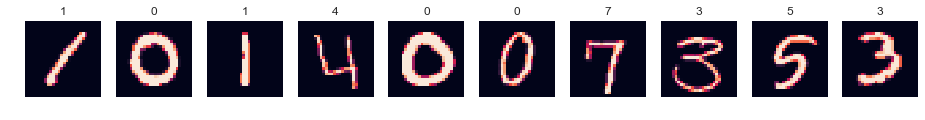

In [6]:
################################################################
num = 10
fig, axes = plt.subplots(1, num, figsize=(16,16))
for i in range (0,num):
    label = df['label'].iloc[i]
    img = df.iloc[i].drop(labels).values.reshape(28,28)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')
################################################################

In [7]:
def show_imgs(df, num=20):
    fig, axes = plt.subplots(1, num, figsize=(16,16))
    for i in range (0,num):
        label = y_pred[i]
        img = df.iloc[i].values.reshape(28,28)
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')

In [8]:
## Preprocess
y  = df[labels]
X  = df.drop(columns=labels)

#scaling = bad
#PCA = bad

In [9]:
## Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
## Training
print "Training classifier..."
clf = RandomForestClassifier(n_estimators=64, random_state=128)
clf.fit(X_train, y_train.values.ravel())
print "Selected classifier accuracy:", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)

Training classifier...
Selected classifier accuracy: 0.9630952380952381


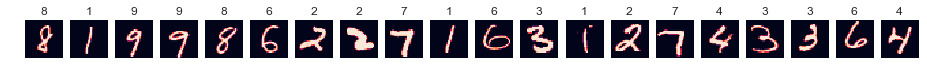

In [11]:
# Display image with predicted label
show_imgs(X_test)

In [12]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print cnf_matrix
#plot_confusion_matrix(cnf_matrix, classes=['Survived','Not Survived'], title='Confusion matrix, without normalization')

[[806   0   1   1   1   0   3   0   3   1]
 [  0 901   3   2   1   1   1   0   0   0]
 [  3   5 809   2  12   1   5   4   5   0]
 [  2   1   7 887   1  10   0  11   8  10]
 [  1   0   2   0 812   0   6   2   0  16]
 [  3   1   1   8   0 665  10   2   7   5]
 [  7   1   0   0   2   6 763   0   6   0]
 [  1   4  11   2   3   1   0 855   2  14]
 [  1   4   4   6   5   3   4   2 799   7]
 [  2   2   1  15   8   4   0  11   2 793]]


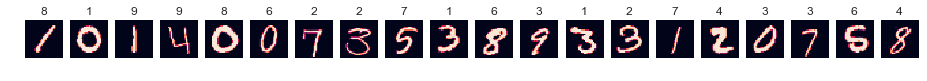

In [13]:
# Display misclassifications
failed = []
for i, (truth, prediction, label) in enumerate(zip(y_test.values.ravel(), y_pred, y.values.ravel())):
    if prediction != label:
        failed.append(i)
        #print i, '~', truth, 'has been classified as ', prediction, 'and should be ', label
df_fail = df.loc[failed].drop(labels, axis=1)
    
show_imgs(df_fail)

In [14]:
#y_pred_proba = clf.predict_proba(X_test)[::,1]
y_pred_proba = clf.predict_proba(X_test)

n_classes = len(clf.classes_)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

TypeError: unhashable type

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

y  = df[labels]
X  = df.drop(columns=labels)

# scaler = RobustScaler()
# X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
## Training
print "Training classifier..."
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train.values.ravel())
print "Selected classifier accuracy:", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)